# Lane Finding

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
image = cv2.imread('./data/test.jpg') # BGR
cv2.imshow("test", image)
cv2.waitKey()
cv2.destroyAllWindows()

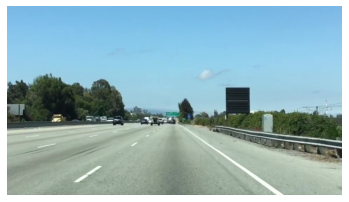

In [3]:
image = mpimg.imread('./data/test.jpg') # RGB
plt.axis('off')
plt.imshow(image)

### Color Selection

Color Picker Tool로 해당 이미지 색상의 RGB 코드값 얻어오기
https://annystudio.com/software/colorpicker/#download

In [4]:
# 각 채널 가져오기 - numpy
r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]

# 각 채널 가져오기 - cv2
b, g, r = cv2.split(image)

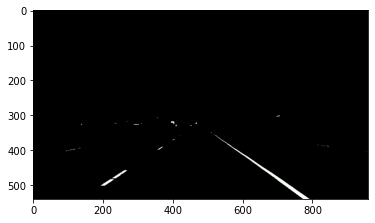

In [5]:
color_select = np.copy(image)

rgb_threshold = [230, 230, 230]

# 각 채널 가져오기 - numpy
thresholds = ((image[:, :, 0] < rgb_threshold[0]) | (image[:, :, 1] < rgb_threshold[1]) | (image[:, :, 2] < rgb_threshold[2]))

color_select[thresholds] = [0, 0, 0]
plt.imshow(color_select)

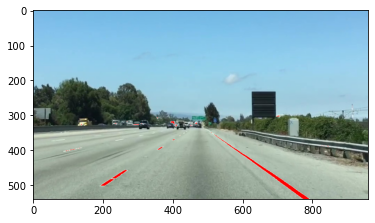

In [6]:
color_select = np.copy(image)

rgb_threshold = [230, 230, 230]
thresholds = ((image[:, :, 0] > rgb_threshold[0]) & (image[:, :, 1] > rgb_threshold[1]) & (image[:, :, 2] > rgb_threshold[2]))

color_select[thresholds] = [255, 0, 0]
plt.imshow(color_select)

### Region Selection

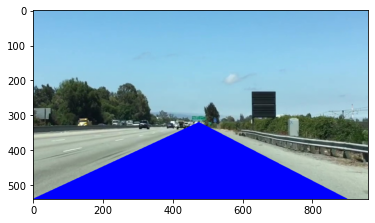

In [7]:
image = mpimg.imread('./data/test.jpg')

left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

region_select = np.copy(image)

pts = np.array([left_bottom, right_bottom, apex])

cv2.fillPoly(region_select, [pts], color=[0, 0, 255])
plt.imshow(region_select)

### Color and Region Selection

In [8]:
image = mpimg.imread('./data/test.jpg')

# Color Selection
color_select = np.copy(image)

rgb_threshold = [230, 230, 230]
color_thresholds = ((image[:, :, 0] < rgb_threshold[0]) | (image[:, :, 1] < rgb_threshold[1]) | (image[:, :, 2] < rgb_threshold[2]))

color_select[thresholds] = [0, 0, 0] # 배경을 검은색으로 마스킹


# Region Selection
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

region_select = np.copy(image)

pts = np.array([left_bottom, right_bottom, apex])

cv2.fillPoly(region_select, [pts], color=[0, 0, 255])

region_thresholds = ((region_select[:, :, 0] == 0) & (region_select[:, :, 1] == 0) & (region_select[:, :, 2] == 255))                  

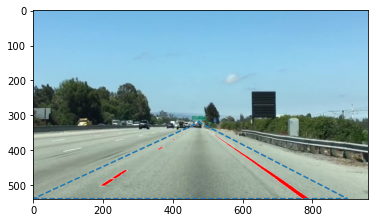

In [9]:
lane_select = np.copy(image)
lane_select[~color_thresholds & region_thresholds] = [255, 0, 0]

x = left_bottom[0], right_bottom[0], apex[0], left_bottom[0]
y = left_bottom[1], right_bottom[1], apex[1], left_bottom[1]
plt.plot(x ,y, '--', 4)

plt.imshow(lane_select)

### Canny Edge Detection

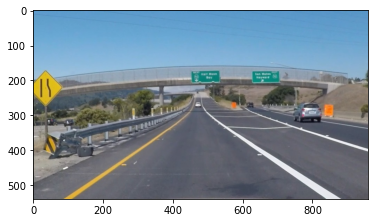

In [10]:
image = mpimg.imread('./data/exit-ramp.jpg')
plt.imshow(image)

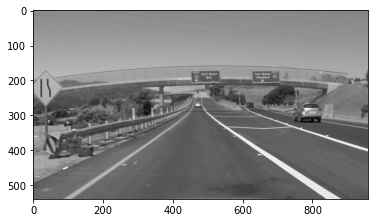

In [11]:
# convert grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

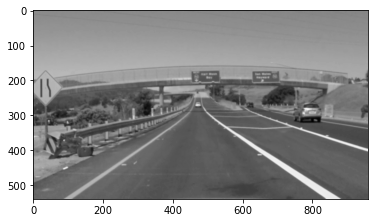

In [12]:
# Blurring
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
plt.imshow(blur_gray, cmap='gray')

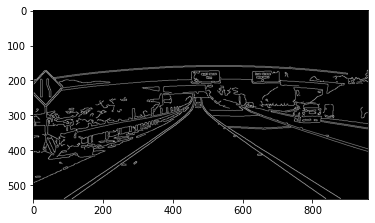

In [13]:
# Edge Detect

# 픽셀의 변화 = 1:2 or 1:3 이 좋다
low_threshold = 50
high_threshold = 150

edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

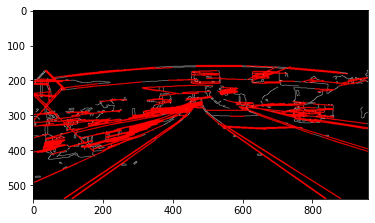

In [14]:
### Hough Transform : 직선 추출
rho = 1
theta = np.pi/180
threshold = 50 # 직선으로 판단할 수 있는 허프 공간에서 교차점 개수
min_line_length = 40
max_line_gap = 20
lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

# color_edges.shape <= 540, 960, 3
# color_edges = cv2.cvtColor(edges, cv2.COLOR2BGR)
color_edges = np.dstack((edges, edges, edges))
"""
dstack : [1, 2, 3], [4, 5, 6] => [[1, 4], [2. 5]. [3, 6]]
hstack : 두 배열을 가로로 이어붙임 (= concatenate((배열1, 배열2), axis=1) )
vstack : 두 배열을 세로로 이어붙임 (= concatenate((배열1, 배열2), axis=0) )

"""
# print(lines.shape)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_edges, (x1,y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(color_edges)

In [15]:
image.shape

(540, 960, 3)

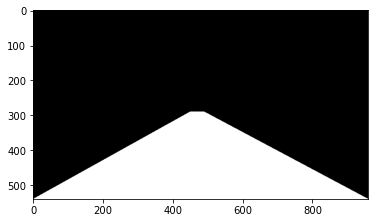

In [16]:
### ROI Selection
# pts : 평행사변형 (좌하단, 좌상단, 우상단, 우하단)
pts = np.array([(0,image.shape[0]), (450, 290), (490, 290), (image.shape[1], image.shape[0])])

mask = np.zeros(edges.shape, edges.dtype)
cv2.fillPoly(mask, [pts], (255, 255, 255))

plt.imshow(mask, cmap='gray')

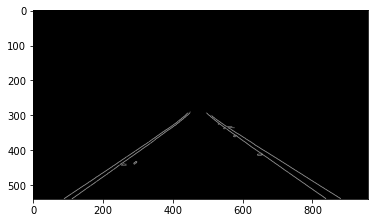

In [17]:
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap='gray')

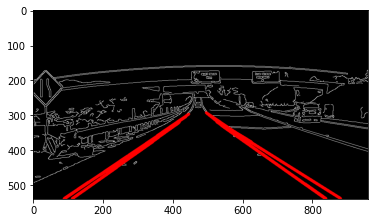

In [22]:
### ROI Selection and Hough Transform
image = mpimg.imread('./data/exit-ramp.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

mask = np.zeros(edges.shape, edges.dtype)
pts = np.array([[(0,image.shape[0]), (450, 290), (490, 290), (image.shape[1], image.shape[0])]])
cv2.fillPoly(mask, pts, (255, 255, 255))

masked_edges = cv2.bitwise_and(edges, mask)

rho = 1
theta = np.pi/180
threshold = 30
min_line_length = 40
max_line_gap = 20

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
color_edges = np.dstack((edges, edges, edges))


if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(color_edges, (x1,y1), (x2, y2), (255, 0, 0), 7)
plt.imshow(color_edges, cmap='gray')

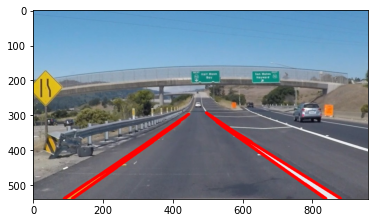

In [19]:
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1,y1), (x2, y2), (255, 0, 0), 7)
plt.imshow(image, cmap='gray')

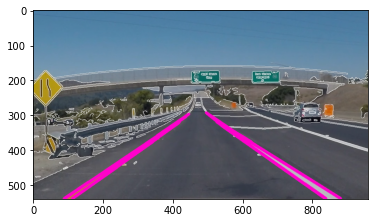

In [26]:
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1,y1), (x2, y2), (0, 0, 255), 7)

result = cv2.addWeighted(image, 0.8, color_edges, 1, 0)
plt.imshow(result)